In [1]:
import oceanspy as ospy
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import numpy as np
import scipy as sp
from detection import eddyDetection
import ast
from tqdm import tqdm
from detection import full_inner_eddy_region_v2
from IPython.display import Video, display
from animation import animation_local_gif
from PIL import Image
import IPython.display as ipy_display
import ipywidgets as widgets

In [2]:
df_OW = xr.open_dataset('D:/MScData/Horizontal_Okubo_weiss.nc')['Okubo_Weiss']
df_OW = df_OW*(1/(10**(-9)))
df_eta = xr.open_dataset('D:/MScData/Horizontal_Eta.nc')['Eta']
df_hor_vel = xr.open_dataset('D:/MScData/Horizontal_hor_vel.nc')['hor_vel']

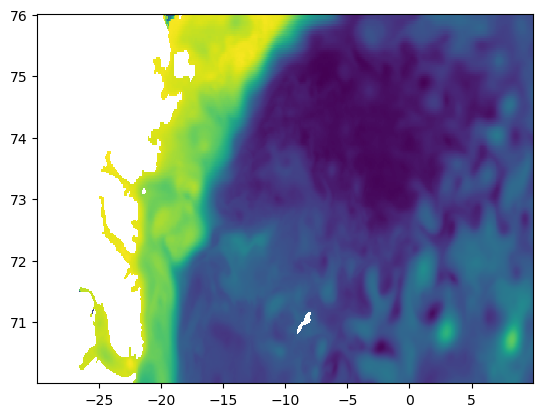

In [3]:
fig, ax = plt.subplots()
ax.pcolormesh(df_eta.X,df_eta.Y,df_eta[0])

In [4]:
# Inner domain
domain_center = [[-21,0],[71,74]]
OW_center = df_OW
eta_center = df_eta
OW_center = OW_center.sel(X=slice(domain_center[0][0],domain_center[0][1]))
OW_center = OW_center.sel(Y=slice(domain_center[1][0],domain_center[1][1]))
OW_center = OW_center.sel(Z=-1)
eta_center = eta_center.sel(X=slice(domain_center[0][0],domain_center[0][1]))
eta_center = eta_center.sel(Y=slice(domain_center[1][0],domain_center[1][1]))

# Outer domain
eta = df_eta
eta = eta.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2))
eta = eta.sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2))

# Resample data
eta = eta.resample(time='D').mean(dim='time')
OW_center = OW_center.resample(time='D').mean(dim='time')
eta_center = eta_center.resample(time='D').mean(dim='time')
hor_vel = df_hor_vel.resample(time='D').mean(dim='time')

# Define time extent
time = ['2018-01-01T00:00:00.000000000','2018-01-31T00:00:00.000000000']
eta = eta.sel(time=slice(time[0],time[1]))
eta_center = eta_center.sel(time=slice(time[0],time[1]))
OW_center = OW_center.sel(time=slice(time[0],time[1]))

hor_vel = hor_vel.sel(X=slice(domain_center[0][0]-2,domain_center[0][1]+2)).sel(Y=slice(domain_center[1][0]-2,domain_center[1][1]+2)).sel(Z=-1).sel(time=slice(time[0],time[1]))

# Running algorythm for eddy center location

In [5]:
# Set True to run, or read previously file made
run = input('Would you like to run a new dataset? y/n: ')
if run == 'y':
    run = True
elif run == 'n':
    run = False
if run:
    eddyLocation = []
    print('###Applying filter###')
    for i in range(len(eta)):
        eddyLocation.append(eddyDetection(eta_center[i],OW_center[i]))
        print('Processing: ',100*(i+1)/len(eta_center), '%')
    with open("eddyCenterpoints_test.txt",'w') as f:
        for time in range(len(eddyLocation)):
            if time != len(eddyLocation)-1:
                f.write(str(eddyLocation[time])+',')
            else:
                f.write(str(eddyLocation[time]))

else:
    print('###Loading previously saved eddy centerpoints###')
    with open("eddyCenterpoints_test2.txt",'r') as f:
        data = f.read()
        eddyLocation = ast.literal_eval(data)

###Loading previously saved eddy centerpoints###


# Running algorythm to find inner eddy region

In [6]:
run = input('Would you like to run a new dataset? y/n: ')
if run == 'y':
    run = True
elif run == 'n':
    run = False

if run:
    eddy_centers = eddyLocation
    T = len(eddyLocation)
    pbar = tqdm(total=T, desc="Running algorythm")
    eddies = xr.full_like(eta,fill_value=0)
    eddies = eddies.rename("EddyDetection")
    for time in range(len(eddyLocation)):
        # First run per time step
        
        
        eddyDataset = full_inner_eddy_region_v2(eta=eta[time],eddy_center=eddy_centers[time][0][0],warm=True,eddiesDataset=eddies[time])
        
        for i in range(1,len(eddy_centers[time][0])):
            eddyDataset = full_inner_eddy_region_v2(eta=eta[time],eddy_center=eddy_centers[time][0][i],warm=True,eddiesDataset=eddyDataset)
            
        for i in range(0,len(eddy_centers[time][1])):
            eddyDataset = full_inner_eddy_region_v2(eta=eta[time],eddy_center=eddy_centers[time][1][i],cold=True,eddiesDataset=eddyDataset)
        
        pbar.update(1)
        eddies[time] = eddyDataset
    eddies.to_netcdf('D:/MScData/EddiesTest.nc')
else:
    eddies = xr.open_dataset('D:/MScData/EddiesTest.nc')
    eddies = eddies['EddyDetection']

Running algorythm:   0%|          | 0/31 [00:00<?, ?it/s]

Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:   3%|▎         | 1/31 [01:14<37:07, 74.23s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:   6%|▋         | 2/31 [02:34<37:38, 77.87s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc


Running algorythm:  10%|▉         | 3/31 [03:58<37:40, 80.75s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  13%|█▎        | 4/31 [05:17<36:03, 80.12s/it]

Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  16%|█▌        | 5/31 [06:37<34:38, 79.96s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc


Running algorythm:  19%|█▉        | 6/31 [07:54<32:53, 78.93s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc


Running algorythm:  23%|██▎       | 7/31 [09:20<32:31, 81.30s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  26%|██▌       | 8/31 [10:41<31:03, 81.00s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc


Running algorythm:  29%|██▉       | 9/31 [11:56<29:05, 79.36s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc


Running algorythm:  32%|███▏      | 10/31 [13:01<26:11, 74.82s/it]

Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  35%|███▌      | 11/31 [14:08<24:10, 72.53s/it]

Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  39%|███▊      | 12/31 [15:09<21:48, 68.89s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  42%|████▏     | 13/31 [16:22<21:05, 70.30s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc


Running algorythm:  45%|████▌     | 14/31 [17:43<20:49, 73.49s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc


Running algorythm:  48%|████▊     | 15/31 [19:03<20:04, 75.29s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  52%|█████▏    | 16/31 [20:18<18:48, 75.24s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  55%|█████▍    | 17/31 [21:37<17:50, 76.47s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  58%|█████▊    | 18/31 [22:56<16:43, 77.17s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  61%|██████▏   | 19/31 [24:08<15:07, 75.62s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  65%|██████▍   | 20/31 [25:21<13:43, 74.86s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  68%|██████▊   | 21/31 [26:42<12:45, 76.59s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  71%|███████   | 22/31 [27:54<11:17, 75.22s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  74%|███████▍  | 23/31 [29:30<10:51, 81.43s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc
Error in X domain: No change in eta detected. To low extent etc


Running algorythm:  77%|███████▋  | 24/31 [30:57<09:42, 83.19s/it]

Error in Y domain: No change in eta detected. To low extent etc


Running algorythm:  81%|████████  | 25/31 [32:16<08:11, 81.99s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc


Running algorythm:  84%|████████▍ | 26/31 [33:31<06:38, 79.72s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  87%|████████▋ | 27/31 [34:55<05:23, 80.98s/it]

Error in XY domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  90%|█████████ | 28/31 [36:18<04:04, 81.59s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc


Running algorythm:  94%|█████████▎| 29/31 [37:41<02:44, 82.13s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc
Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm:  97%|█████████▋| 30/31 [39:01<01:21, 81.55s/it]

Error in Y domain: No change in eta detected. To low extent etc
Error in XY domain: No change in eta detected. To low extent etc


Running algorythm: 100%|██████████| 31/31 [40:29<00:00, 83.45s/it]

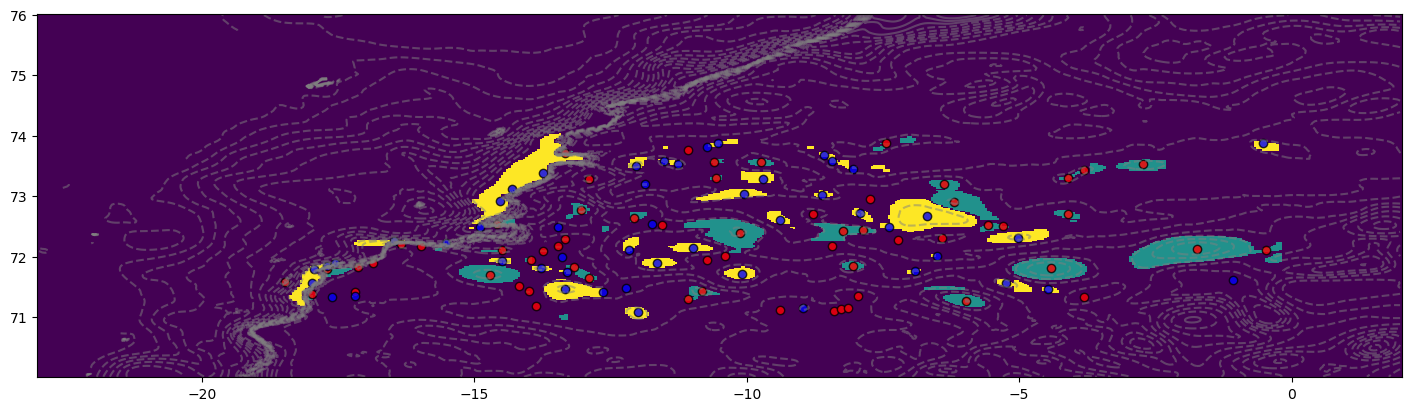

In [7]:
Eddy_locations = eddy_centers[1]
fig , ax = plt.subplots(figsize=(14,4),layout='constrained')
ax.pcolormesh(eta.X,eta.Y,eddies[1])
ax.contour(eta.X,eta.Y,eta[1],np.linspace(-0.4,0.1,21),colors='grey',alpha=0.5)
for i in Eddy_locations[0]:
    sct1 = ax.scatter(i[1],i[0],color='red',edgecolor='black',alpha=0.8)


for i in Eddy_locations[1]:
    sct2 = ax.scatter(i[1],i[0],color='blue',edgecolor='black',alpha=0.8)

In [8]:
# df_depth = xr.open_dataset('C:/Users/eirik/Master/Data/depth.nc')
# depth = df_depth['Depth'].sel(X=slice(eddies.X[0], eddies.X[-1])).sel(Y=slice(eddies.Y[0], eddies.Y[-1]))

# from IPython.display import Image, display
# # animation_local_gif(data=eddies,name='Eddies_1DTest',unit='No eddy, Warm eddy, Cold eddy',depth=depth,interval=200)
# display(Image('Eddies_1DTest.gif'))

# Testing out eddy outer region detection

In [9]:
from detection import outer_eddy_region

eddies_full = eddies.copy()
run = input('Run outer eddy domain? (y/n): ')
if run == 'y':
    for time in range(len(eddies_full.time)):
        data = outer_eddy_region(hor_vel=hor_vel[time],eddiesDataset=eddies_full[time])
        print('Progress: ',100*(time+1)/len(eddies.time))
        data = data.where(data != 0, np.nan)
        eddies_full[time] = data
        eddies_full.to_netcdf('D:/MScData/eddies_fullTest.nc')
elif run == "n":
    eddies_full = xr.open_dataset('D:/MScData/eddies_fullTest.nc')['EddyDetection']

Running outer region algorythm: 100%|██████████| 258/258 [01:24<00:00,  3.06it/s]


Progress:  3.225806451612903


Running outer region algorythm: 100%|██████████| 258/258 [01:22<00:00,  3.15it/s]


Progress:  6.451612903225806


Running outer region algorythm: 100%|██████████| 258/258 [01:21<00:00,  3.16it/s]


Progress:  9.67741935483871


Running outer region algorythm: 100%|██████████| 258/258 [01:22<00:00,  3.13it/s]


Progress:  12.903225806451612


Running outer region algorythm: 100%|██████████| 258/258 [01:28<00:00,  2.90it/s]


Progress:  16.129032258064516


Running outer region algorythm: 100%|██████████| 258/258 [01:31<00:00,  2.83it/s]


Progress:  19.35483870967742


Running outer region algorythm: 100%|██████████| 258/258 [01:34<00:00,  2.74it/s]


Progress:  22.580645161290324


Running outer region algorythm: 100%|██████████| 258/258 [01:27<00:00,  2.94it/s]


Progress:  25.806451612903224


Running outer region algorythm: 100%|██████████| 258/258 [01:20<00:00,  3.19it/s]


Progress:  29.032258064516128


Running outer region algorythm: 100%|██████████| 258/258 [01:18<00:00,  3.28it/s]


Progress:  32.25806451612903


Running outer region algorythm: 100%|██████████| 258/258 [01:18<00:00,  3.31it/s]


Progress:  35.483870967741936


Running outer region algorythm: 100%|██████████| 258/258 [01:21<00:00,  3.17it/s]


Progress:  38.70967741935484


Running outer region algorythm: 100%|██████████| 258/258 [01:24<00:00,  3.05it/s]


Progress:  41.935483870967744


Running outer region algorythm: 100%|██████████| 258/258 [01:24<00:00,  3.07it/s]


Progress:  45.16129032258065


Running outer region algorythm: 100%|██████████| 258/258 [01:25<00:00,  3.00it/s]


Progress:  48.38709677419355


Running outer region algorythm: 100%|██████████| 258/258 [01:26<00:00,  2.99it/s]


Progress:  51.61290322580645


Running outer region algorythm: 100%|██████████| 258/258 [01:26<00:00,  2.98it/s]


Progress:  54.83870967741935


Running outer region algorythm: 100%|██████████| 258/258 [01:24<00:00,  3.05it/s]


Progress:  58.064516129032256


Running outer region algorythm: 100%|██████████| 258/258 [01:23<00:00,  3.10it/s]


Progress:  61.29032258064516


Running outer region algorythm: 100%|██████████| 258/258 [01:18<00:00,  3.28it/s]


Progress:  64.51612903225806


Running outer region algorythm: 100%|██████████| 258/258 [01:17<00:00,  3.35it/s]


Progress:  67.74193548387096


Running outer region algorythm: 100%|██████████| 258/258 [01:16<00:00,  3.35it/s]


Progress:  70.96774193548387


Running outer region algorythm: 100%|██████████| 258/258 [01:17<00:00,  3.35it/s]


Progress:  74.19354838709677


Running outer region algorythm: 100%|██████████| 258/258 [01:18<00:00,  3.27it/s]


Progress:  77.41935483870968


Running outer region algorythm: 100%|██████████| 258/258 [01:18<00:00,  3.30it/s]


Progress:  80.64516129032258


Running outer region algorythm: 100%|██████████| 258/258 [01:23<00:00,  3.11it/s]


Progress:  83.87096774193549


Running outer region algorythm: 100%|██████████| 258/258 [01:24<00:00,  3.05it/s]


Progress:  87.09677419354838


Running outer region algorythm: 100%|██████████| 258/258 [01:24<00:00,  3.04it/s]


Progress:  90.3225806451613


Running outer region algorythm: 100%|██████████| 258/258 [01:25<00:00,  3.01it/s]


Progress:  93.54838709677419


Running outer region algorythm: 100%|██████████| 258/258 [01:27<00:00,  2.95it/s]


Progress:  96.7741935483871


Running outer region algorythm: 100%|██████████| 258/258 [01:29<00:00,  2.90it/s]

Progress:  100.0


In [10]:
# print(eddies_full.max().values)
# display(hor_vel[0].max() > 0.7)

# display(eddies[0][-10+11:10+11,-10+11:10+11].max())

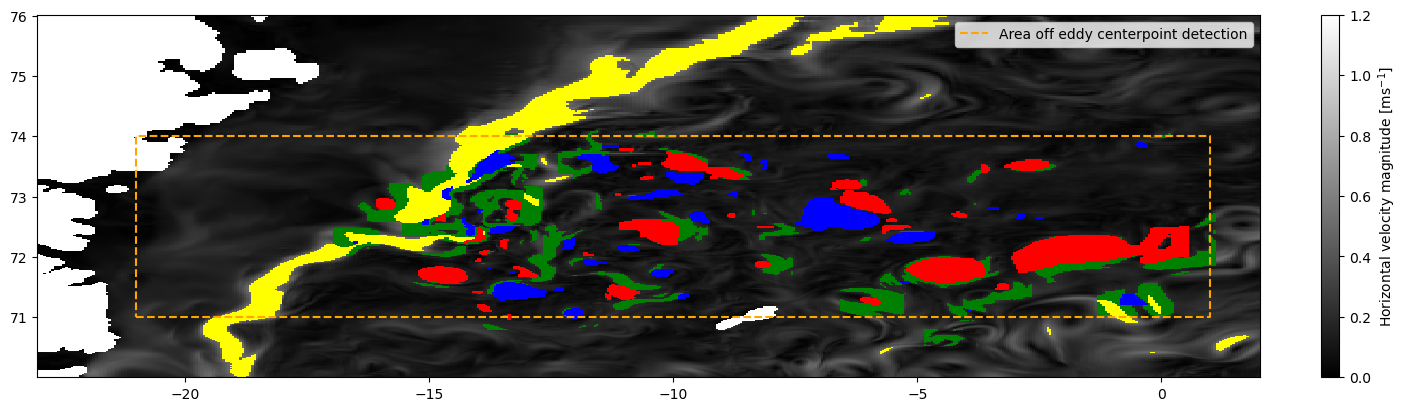

In [11]:
# 1 = warm, 2 = cold, 3 = current, 4 = stream
import matplotlib.colors as mcolors

# Define the custom colormap
colors = ['red', 'blue', 'yellow', 'green']
cmap = mcolors.ListedColormap(colors)

# Define the normalization
bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(figsize=(14,4),layout='constrained')
mesh = ax.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[0],vmin=0,vmax=1.2,cmap='binary_r')
cbar = fig.colorbar(mesh)
cbar.set_label('Horizontal velocity magnitude [ms$^{-1}$]')
ax.pcolormesh(eddies_full.X,eddies_full.Y,eddies_full[0],cmap=cmap, norm=norm)
x = [-21,1,1,-21,-21]
y = [71,71,74,74,71]
ax.plot(x,y,color='orange',linestyle='--', label='Area off eddy centerpoint detection')
ax.legend()


In [12]:
# # Define the custom colormap
# colors = ['red', 'blue', 'yellow', 'green']
# cmap = mcolors.ListedColormap(colors)

# # Define the normalization
# bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
# norm = mcolors.BoundaryNorm(bounds, cmap.N)
# for i in range(len(eddies_full.time)):
#     fig, ax = plt.subplots(figsize=(14,4),layout='constrained')
#     mesh = ax.pcolormesh(hor_vel.X,hor_vel.Y,hor_vel[i],cmap='binary_r')
#     cbar = fig.colorbar(mesh)
#     cbar.set_label('Horizontal velocity magnitude [ms$^{-1}$]')
#     ax.pcolormesh(eddies_full.X,eddies_full.Y,eddies_full[i],cmap=cmap, norm=norm)
#     plt.savefig(f'C:/Users/eirik/Master/Figures/FullEddyArea/{i}figFullEddy')

Generating Frames: 63it [00:35,  1.76it/s]


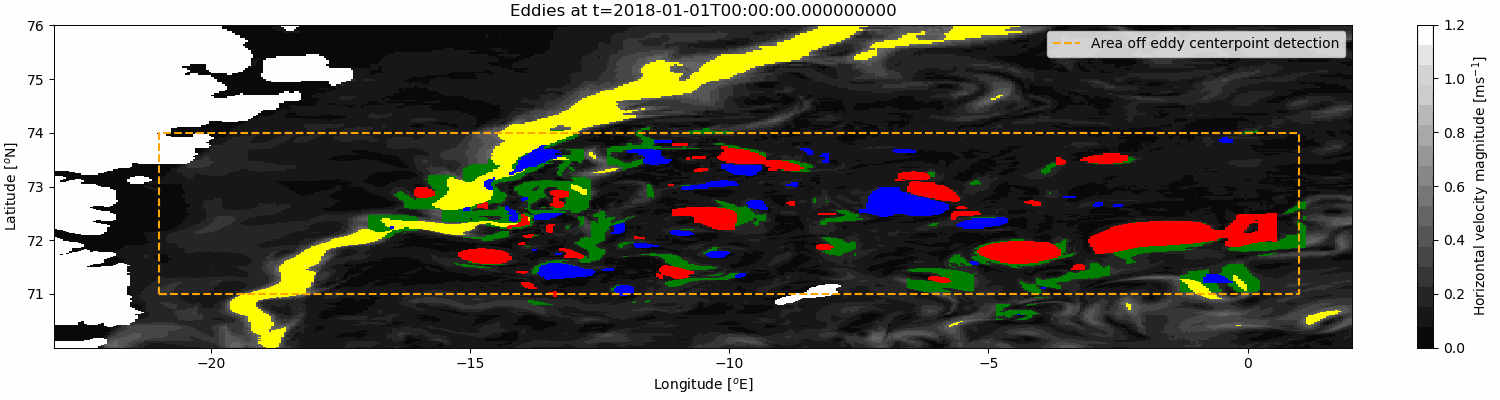

In [13]:
# Animation of Eddies
from animation import animate_eddies
animate_eddies(eddies_full=eddies_full,hor_vel=hor_vel,fname='TestOldEddiesMethod')